In [1]:
# FOR GETTING VALIDATION DATA WHEN TESTING LEARNED MODEL
%load_ext autoreload
%autoreload
import matplotlib.pyplot as plt
import train
import numpy as np
import glob
import torch
from PIL import Image


import data_utils.dataset as ds
import utils.optimizer_utils as optim_utils
import utils.diffuser_utils as diffuser_utils
from utils.helper_functions import read_config
import os
device = torch.device("cuda:0")

torch.cuda.get_device_name(device)
torch.tensor([1,2,3]).to(device)

tensor([1, 2, 3], device='cuda:0')

In [6]:

defocuscamdata_path = "/home/cfoley_waller/defocam/defocuscamdata"
calib_mat_path_rel = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/calib_matrix_full_10_18_2023_NEW_exp26.64ms_gain14.9_navg16_378_890/calibration_matrix.mat"
psf_path_rel = "calibration_data/DMM_37UX178_ML_calib_data/psf_selected_10_18_2023_new_noiseavg32"
data_path_rel = "sample_data"
test_meas_path_rel = "calibration_data/DMM_37UX178_ML_calib_data/exp_meas_selected_10_18_car_NEW"
data_split = (0.7, 0.15, 0.15)

#exp params
crop_offset = [500, 1500]
crop_size = [768, 768] 
patch_size = [256, 256] #final patch size to downsample to

#sim params
image_index = 13
sim_meas = True

base_data_path = os.path.join(defocuscamdata_path, data_path_rel)

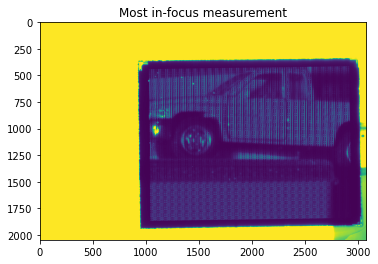

In [7]:
crop = lambda im: im[crop_offset[0]:crop_offset[0] + crop_size[0], crop_offset[1]:crop_offset[1] + crop_size[1]]
one_norm = lambda im: (im - np.min(im)) / np.max(im - np.min(im))
measurements = [Image.open(x) for x in sorted(glob.glob(os.path.join(defocuscamdata_path, test_meas_path_rel, "*.bmp")))]

full = np.array(measurements[0])
plt.imshow(full)
plt.title("Most in-focus measurement")
plt.show()

measurements = [diffuser_utils.pyramid_down(crop(np.array(x)), patch_size) for x in measurements]
meas_stack = torch.tensor(np.stack(one_norm(measurements), axis=0))

In [8]:
### Setup & specify the training config file
config = "/home/cfoley_waller/defocam/SpectralDefocusCam/config_files/training/train_10_14_2023_stack3_exp_blur_r2attn.yml" 
config = read_config(config)

cuda:0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24268MB, multi_processor_count=82)


validating:   0%|          | 0/20 [00:00<?, ?it/s]

cuda:0
Loaded model...


validating:  40%|████      | 8/20 [03:12<11:10, 55.86s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0dc50a3310>
Traceback (most recent call last):
  File "/home/cfoley_waller/anaconda3/envs/SpectralDiffuserCam/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/cfoley_waller/anaconda3/envs/SpectralDiffuserCam/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/cfoley_waller/anaconda3/envs/SpectralDiffuserCam/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


0.0071765428147045895


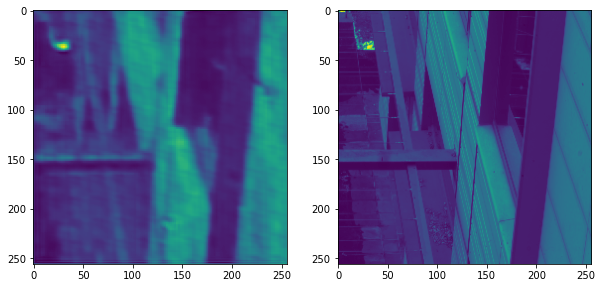

In [8]:
### First check whether simulated measurements from the validation set are reconstructing
config["forward_model_params"]["sim_meas"] = True

model = train.get_model(config, device = device)
print("Loaded model...")

trn, val, tst = ds.get_data(1, data_split, base_data_path, patch_size, 1)
loss_function = optim_utils.get_loss_function(
        config["loss_function"]["name"], config["loss_function"]["params"]
    )
print("Loaded data...")

val_loss, test_np, gt_np = train.evaluate(model, val, loss_function, device)
print("Validation loss: ", val_loss)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(np.mean(test_np,0))
ax[1].imshow(np.mean(gt_np, 0))
plt.show()

cuda:0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24268MB, multi_processor_count=82)
cuda:0
Loaded model...


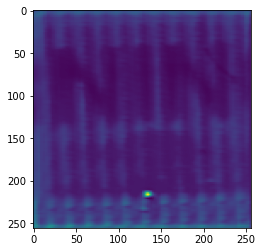

In [12]:
### Then we can try to reconstruct an experimental measurement
config["forward_model_params"]["sim_meas"] = False
config["forward_model_params"]["sim_blur"] = False
config["forward_model_params"]["apply_adjoint"] = True
config["forward_model_params"]["spectral_pad_output"] = True
model = train.get_model(config, device = device)
print("Loaded model...")

meas_stack_tensor = meas_stack.unsqueeze(0).to(device).float()
out = model(meas_stack_tensor)
plt.imshow(np.mean(out.detach().cpu().numpy()[0], 0))
plt.show()